In [1]:
import tensorflow as tf
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, stft, istft
import matplotlib.pyplot as plt
import librosa
import librosa.display
from misceallaneous import getWavFileAsNpArray, displaySpectrogram
from IPython.display import Audio

samplerate = 12000

In [93]:
clean = getWavFileAsNpArray("../dataset_2/clean/p1.wav")
vinyl = getWavFileAsNpArray("../dataset_2/white/p1.wav")

In [94]:
nperseg = 1024

c, t, Cxx = stft(np.array(clean), fs=samplerate, nperseg=nperseg)
d, u, Vxx = stft(np.array(vinyl), fs=samplerate, nperseg=nperseg)

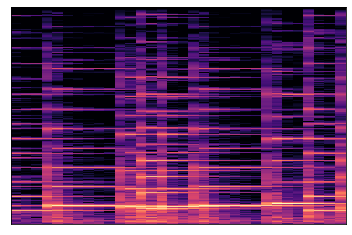

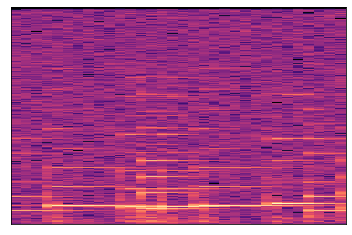

In [95]:
displaySpectrogram(Cxx[:, 32:64])
plt.show()
displaySpectrogram(Vxx[:, 32:64])
plt.show()

In [96]:
Cxx = Cxx[1:, :]
Vxx = Vxx[1:, :]
print(Cxx.shape, Vxx.shape)

(512, 21320) (512, 21320)


In [97]:
Cxx_split = []
Vxx_split = []

In [98]:
samples_length = 32
for i in range(0, Cxx.shape[1]-samples_length, samples_length):
    Cxx_split.append(np.reshape(np.array(Cxx[:, i:i+samples_length]), (Cxx.shape[0], samples_length, 1)))
    Vxx_split.append(np.reshape(np.array(Vxx[:, i:i+samples_length]), (Cxx.shape[0], samples_length, 1)))
Cxx_split = np.array(Cxx_split)
Vxx_split = np.array(Vxx_split)

In [99]:
print(Cxx_split.shape)

(666, 512, 32, 1)


In [100]:
Cxx_r = np.abs(Cxx_split)
Cxx_i = np.imag(Cxx_split)
Vxx_r = np.abs(Vxx_split)
Vxx_i = np.imag(Vxx_split)
print(Cxx_r.shape)

(666, 512, 32, 1)


In [109]:
ker1 = (16, 4)
ker2 = (1, 4)

def simple_autoencoder(input_shape, V_shape_1):
    print(input_shape)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(1, kernel_size = ker1,  activation = 'relu', input_shape = input_shape, padding='same', data_format='channels_last')) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 1)))
    
    model.add(tf.keras.layers.Conv2D(1, ker1, activation = 'relu', padding='same'))
    
    model.add(tf.keras.layers.Conv2D(1, ker1, activation = 'relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 1)))
    
    model.add(tf.keras.layers.Conv2D(1, ker1, activation = 'relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 1)))
    
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(V_shape_1*V_shape_1/8, activation = 'relu'))
    model.add(tf.keras.layers.Dense(V_shape_1*V_shape_1, activation = 'relu'))
    
    model.add(tf.keras.layers.Reshape((V_shape_1, V_shape_1, 1)))
    
    model.add(tf.keras.layers.Conv2D(1, ker2, activation = 'relu', padding='same'))
    model.add(tf.keras.layers.UpSampling2D((2, 1)))
    
    model.add(tf.keras.layers.Conv2D(1, ker2, activation = 'relu', padding='same'))
    model.add(tf.keras.layers.UpSampling2D((2, 1)))
    
    model.add(tf.keras.layers.Conv2D(1, ker2, activation = 'relu', padding='same'))
    model.add(tf.keras.layers.UpSampling2D((2, 1)))
    
    model.add(tf.keras.layers.Conv2D(1, ker2, activation = 'relu', padding='same'))
    model.add(tf.keras.layers.UpSampling2D((2, 1)))
    model.summary()
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

def simple_skip_autoencoder(input_shape, V_shape_1):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x1 = tf.keras.layers.Conv2D(1, kernel_size = ker1,  activation = 'relu', 
                                    input_shape = input_shape, padding='same', data_format='channels_last')(inputs)
    x2 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(x1)
    x3 = tf.keras.layers.Conv2D(1, ker1, activation = 'relu', padding='same')(x2)
    x4 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(x3)
    x5 = tf.keras.layers.Conv2D(1, ker1, activation = 'relu', padding='same')(x4)
    x6 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(x5)
    x7 = tf.keras.layers.Conv2D(1, ker1, activation = 'relu', padding='same')(x6)
    
    x8 = tf.keras.layers.Flatten()(x7)
    x9 = tf.keras.layers.Dense(input_shape[0]//16*input_shape[1]//4, activation = 'relu')(x8)
    x10 = tf.keras.layers.Reshape((input_shape[0]//16, input_shape[1]//4, 1))(x9)
    
    x11 = tf.keras.layers.UpSampling2D((2, 1))(x10)
    x12 = tf.keras.layers.Conv2D(1, ker2, activation = 'relu', padding='same')(x11)
    x13 = tf.keras.layers.UpSampling2D((2, 1))(x12)
    a2 = tf.keras.layers.Add()([x5, x13])
    x14 = tf.keras.layers.Conv2D(1, ker2, activation = 'relu', padding='same')(a2)
    x15 = tf.keras.layers.UpSampling2D((2, 2))(x14)
    a3 = tf.keras.layers.Add()([x3, x15])
    x16 = tf.keras.layers.Conv2D(1, ker2, activation = 'relu', padding='same')(a3)
    outputs = tf.keras.layers.UpSampling2D((2, 2))(x16)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="skip_autoencoder")
    model.summary()
    model.compile(optimizer='adadelta', loss='mse', metrics=['accuracy'])
    return model

model = simple_autoencoder((Cxx_r.shape[1], Cxx_r.shape[2], 1), Cxx_r.shape[2])

(512, 32, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_286 (Conv2D)          (None, 512, 32, 1)        65        
_________________________________________________________________
max_pooling2d_121 (MaxPoolin (None, 256, 32, 1)        0         
_________________________________________________________________
conv2d_287 (Conv2D)          (None, 256, 32, 1)        65        
_________________________________________________________________
conv2d_288 (Conv2D)          (None, 256, 32, 1)        65        
_________________________________________________________________
max_pooling2d_122 (MaxPoolin (None, 128, 32, 1)        0         
_________________________________________________________________
conv2d_289 (Conv2D)          (None, 128, 32, 1)        65        
_________________________________________________________________
max_pooling2d_123 (MaxPoolin (None, 64, 3

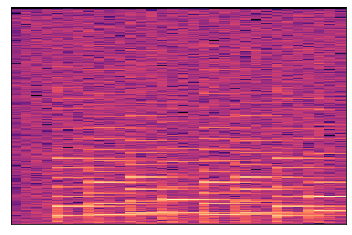

Epoch 1/5
505/666 [=====================>........] - ETA: 4s - loss: 34774.7027 - accuracy: 0.0013

KeyboardInterrupt: 

In [110]:
sample_number = 0
inp = (np.reshape(Vxx_r[sample_number, :], (Vxx_r[sample_number, :].shape[0], Vxx_r[sample_number, :].shape[1])))
displaySpectrogram(inp)
plt.show()
for _ in range(10):
    model.fit(Vxx_r, Cxx_r, batch_size=1, epochs=5)
    layerIndex = -1
    func = tf.keras.backend.function([model.get_layer(index=0).input], model.get_layer(index=layerIndex).output)
    layerOutput = func([Vxx_r])  # input_data is a numpy array
    out = (np.reshape(layerOutput[sample_number], (layerOutput[sample_number].shape[0], layerOutput[sample_number].shape[1])))

    displaySpectrogram(out)
    plt.show()

In [13]:
predict_length = 1000

In [16]:
output = model.predict(Vxx_r[:predict_length, :])
output.shape

(333, 512, 64, 1)

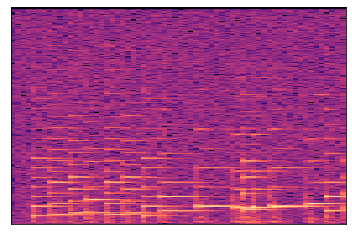

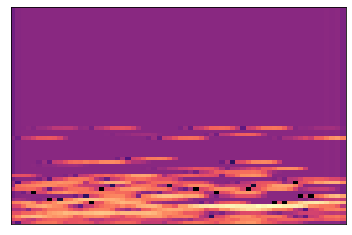

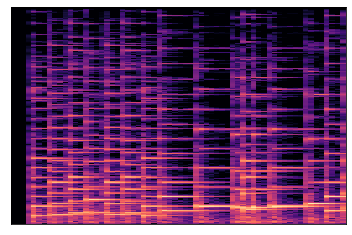

In [23]:
displaySpectrogram(Vxx_r[0, :, :predict_length, 0])
plt.show()
displaySpectrogram(output[0, :, :predict_length, 0])
plt.show()
displaySpectrogram(Cxx_r[0, :, :predict_length, 0])
plt.show()

In [34]:
cleaned_output = istft(output[0, :, :predict_length, 0] + Vxx_i[0, :, :predict_length, 0]*1j, fs=samplerate, nperseg=nperseg)[1]
clean_output = istft(Vxx_r[0, :, :predict_length, 0] + Vxx_i[0, :, :predict_length, 0]*1j, fs=samplerate, nperseg=nperseg)[1]
Audio(clean_output, rate=samplerate)

ValueError: operands could not be broadcast together with shapes (1022,) (1024,) 

In [ ]:
Audio(cleaned_output, rate=samplerate)

It seems that auto encoders are always blurry: therefore, the audio output cannot be precise.